# Neural Style Transfer

Original Paper: https://arxiv.org/abs/1508.06576
Needs imagenet-vgg-verydeep-19.mat

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
#http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style

IMAGE_WIDTH = 800
IMAGE_HEIGHT = 600
COLOR_CHANNELS = 3
#LAYER_NAME_INDEX = -2
LAYER_NAME_INDEX = 0
# WEIGHT_INDEX = 0
WEIGHT_INDEX = 2

def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """

        W = vgg_layers[0][layer][0][0][WEIGHT_INDEX][0][0]
        b = vgg_layers[0][layer][0][0][WEIGHT_INDEX][0][1]
        layer_name = vgg_layers[0][layer][0][0][LAYER_NAME_INDEX]
        assert layer_name == expected_layer_name, "Not equal %r and %r" % (layer_name, expected_layer_name)
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

In [3]:
model = load_vgg_model("./imagenet-vgg-verydeep-19.mat")
print(model)

{'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 600, 800, 64) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 150, 200, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 75, 100, 512) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 300, 400, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 300, 400, 128) dtype=float32>, 'conv5_1': <tf.Tensor 'Relu_12:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 150, 200, 256) dtype=float32>, 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 38, 50, 512) dtype=float32>, 'input': <tf.Variable 'Variable:0' shape=(1, 600, 800, 3) dtype=float32_ref>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 75, 100, 512) dtype=float32>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 75, 100, 512) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0

In [5]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, [m, n_H * n_W, n_C])
    a_G_unrolled =  tf.reshape(a_G, [m, n_H * n_W, n_C])
    
    J_content = (1/(4*n_H*n_W*n_C)) * tf.reduce_sum( tf.square(tf.subtract(a_C_unrolled, a_G_unrolled) ))

    return J_content

In [6]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA

In [7]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape( tf.transpose(a_S) , [n_C, n_H*n_W] )
    a_G = tf.reshape( tf.transpose(a_G) , [n_C, n_H*n_W] )

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = 1/(4 * n_C**2 * (n_H*n_W)**2 ) * tf.reduce_sum(tf.reduce_sum( tf.square(tf.subtract(GS, GG) )))
        
    return J_style_layer

In [8]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [9]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]

        a_S = sess.run(out)
        
        a_G = out
                
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        
        J_style += coeff * J_style_layer

    return J_style

In [10]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style   
    return J

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [12]:
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

def reshape_and_normalize_image(image):
    image = np.reshape(image, ((1,) + image.shape))
    # TODO: data['normalization'][0][0][0] its already in the mat file !!!!!!!!!
    image = image - MEAN_VALUES
    
    return image
def save_image(path, image):
    # Output should add back the mean.
    image = image + MEAN_VALUES
    # Get rid of the first useless dimension, what remains is the image.
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [13]:
content_image = scipy.misc.imread("jasmin_seilbahn.jpg")
content_image = reshape_and_normalize_image(content_image)
#imshow(content_image)
style_image = scipy.misc.imread("monalisa.jpg")
style_image = reshape_and_normalize_image(style_image)

C:\Users\Blup\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\Blup\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


In [14]:
NOISE_RATIO = 0.6

def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.uniform(
            -20, 20,
            (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')

    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


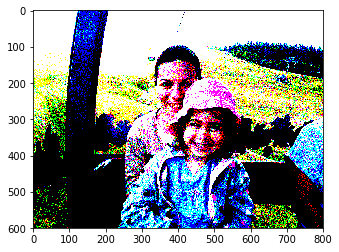

In [15]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [16]:
model = load_vgg_model("./imagenet-vgg-verydeep-19.mat")
sess.run(model['input'].assign(content_image))

out = model['conv4_2']

a_C = sess.run(out)
a_G = out

J_content = compute_content_cost(a_C, a_G)

In [17]:
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, STYLE_LAYERS)

In [18]:
J = total_cost(J_content, J_style, alpha=10, beta=40)


In [19]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [20]:
def model_nn(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):    
        sess.run(train_step, options=tf.RunOptions(report_tensor_allocations_upon_oom = True) )
        generated_image = sess.run(model['input'])
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image("./" + str(i) + ".png", generated_image)
    
    save_image('./generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess, generated_image, num_iterations=300)

Iteration 0 :
total cost = 6186999300.0
content cost = 9420.789
style cost = 154672620.0


C:\Users\Blup\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


Iteration 20 :
total cost = 785393000.0
content cost = 15052.255
style cost = 19631062.0
Iteration 40 :
total cost = 247365150.0
content cost = 16075.953
style cost = 6180110.0
Iteration 60 :
total cost = 114368136.0
content cost = 16391.26
style cost = 2855105.5
Iteration 80 :
total cost = 72323860.0
content cost = 16467.684
style cost = 1803979.4
Iteration 100 :
total cost = 53688988.0
content cost = 16548.879
style cost = 1338087.5
Iteration 120 :
total cost = 43112044.0
content cost = 16626.342
style cost = 1073644.5
Iteration 140 :
total cost = 36122680.0
content cost = 16705.414
style cost = 898890.56
Iteration 160 :
total cost = 31063380.0
content cost = 16785.988
style cost = 772388.0
Iteration 180 :
total cost = 27199374.0
content cost = 16861.516
style cost = 675768.94
Iteration 200 :
total cost = 24150070.0
content cost = 16931.713
style cost = 599518.8
Iteration 220 :
total cost = 21667964.0
content cost = 17000.336
style cost = 537449.0
Iteration 240 :
total cost = 1961070

In [ ]:
#with tf.device('/gpu:0'):
#    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#    c = tf.matmul(a, b)
#
#with tf.Session() as sess:
#    print (sess.run(c))